# Heartbeat Prediction


In [12]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gc
from colorama import Fore, Style
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.over_sampling import SMOTE

cuda_NO = 1
with_SMOTE = False
if_train = True
fix_rand_seed = 1
rand_seed = 37
batch_size = 128
model_save_path = "best_heartbeat_model.pth"

print(torch.cuda.is_available())
device = f"cuda:{cuda_NO}" if torch.cuda.is_available() else "cpu"
print(device)

!nvidia-smi

False
cpu
zsh:1: command not found: nvidia-smi


# Plain Preprocessing

## Set random seed

In [13]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if fix_rand_seed:
    set_rand_seed(rand_seed)

## Read data

In [14]:
train_data = pd.read_csv('train.csv', header=0)

## Check data

In [15]:
# check the data and labels
print(train_data.head())
print(f"labels contain: {train_data['label'].unique()}")

   id                                  heartbeat_signals  label
0   0  0.9912297987616655,0.9435330436439665,0.764677...    0.0
1   1  0.9714822034884503,0.9289687459588268,0.572932...    0.0
2   2  1.0,0.9591487564065292,0.7013782792997189,0.23...    2.0
3   3  0.9757952826275774,0.9340884687738161,0.659636...    0.0
4   4  0.0,0.055816398940721094,0.26129357194994196,0...    2.0
labels contain: [0. 2. 3. 1.]


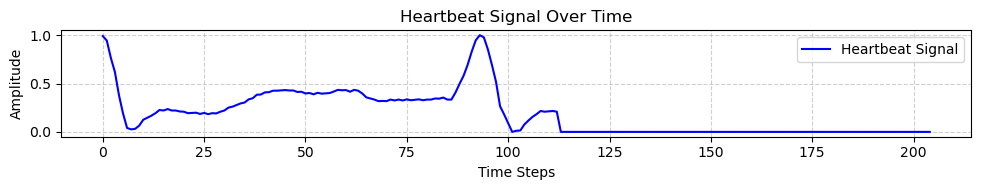

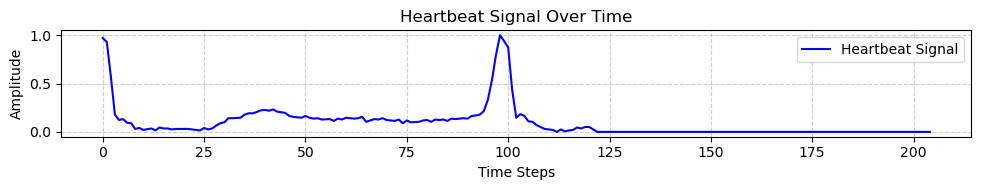

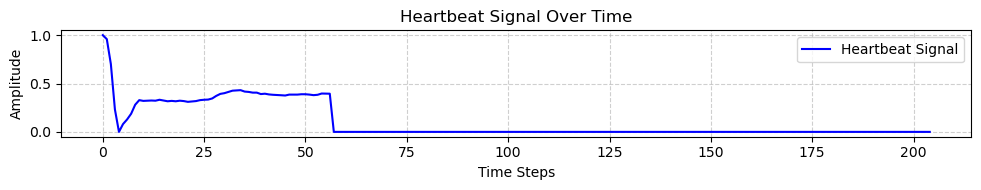

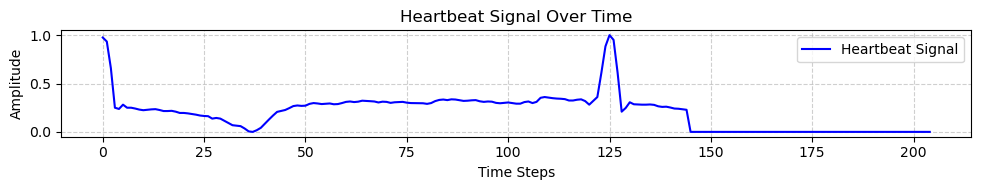

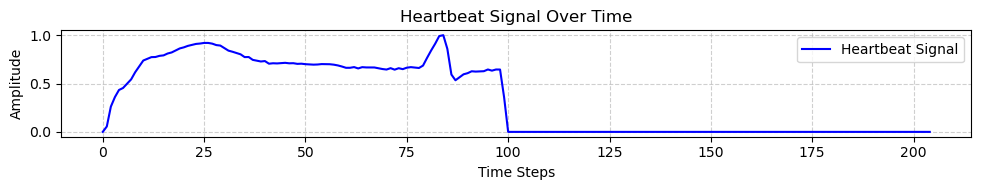

In [16]:
def plot_signal(sample_index):
    heartbeat_signal = train_data['heartbeat_signals'].iloc[sample_index]
    vector = list(map(float, heartbeat_signal.split(',')))

    plt.figure(figsize=(10, 2))
    plt.plot(vector, label="Heartbeat Signal", color='blue')
    plt.title("Heartbeat Signal Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_signal(i)

## Preprocessing functions

In [17]:
# normalization
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def to_array(signal):
    return np.array(list(map(float, signal.split(','))))

# preprocessing
def preprocess_signal(signal):
    signal = to_array(signal) # this comes first!
    # data is already normalized
    return signal

## Split with SMOTE

In [18]:
if with_SMOTE:
    X = train_data['heartbeat_signals']
    y = train_data['label']

    X = X.apply(preprocess_signal)
    y = y.apply(lambda x: int(x))

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rand_seed)

    # SMOTE, to vector
    X_train_flat = np.array([x.flatten() for x in X_train])
    y_train = y_train.values

    smote = SMOTE(random_state=rand_seed)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)

    # recover data to tensor
    X_train_balanced = [np.reshape(x, (-1,)) for x in X_train_balanced]

    # reset index
    X_train, y_train = X_train_balanced, y_train_balanced
    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

## Split without SMOTE

In [19]:
#if not with_SMOTE:
if not with_SMOTE:
    X = train_data['heartbeat_signals']
    y = train_data['label']

    X = X.apply(preprocess_signal)
    y = y.apply(lambda x: int(x))

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=rand_seed)

    # reset index
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_val = X_val.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

## Data Distribution

Category Distribution Before Balancing:
       Count  Percentage(%)
label                      
0.0    64327         64.327
3.0    17912         17.912
2.0    14199         14.199
1.0     3562          3.562


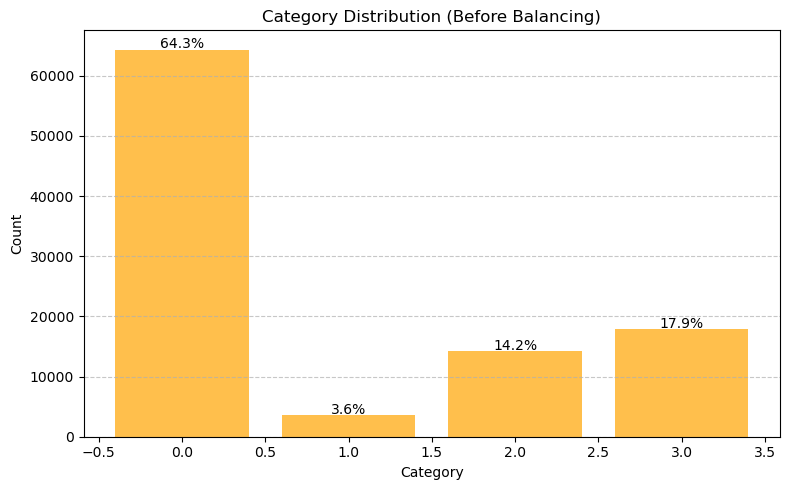

Category Distribution After Balancing:
   Count  Percentage(%)
0  64327           25.0
2  64327           25.0
3  64327           25.0
1  64327           25.0


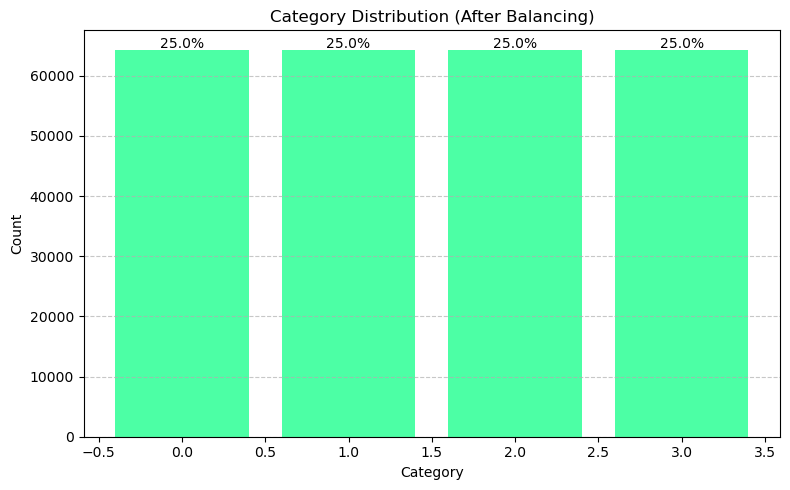

In [20]:
# original data distribution
category_counts_original = train_data['label'].value_counts()
category_percentages_original = category_counts_original / len(train_data) * 100
category_distribution_original = pd.DataFrame({
    'Count': category_counts_original,
    'Percentage(%)': category_percentages_original
})
print("Category Distribution Before Balancing:")
print(category_distribution_original)

# original data visualization
plt.figure(figsize=(8, 5))
plt.bar(category_counts_original.index, category_counts_original.values, alpha=0.7, color='orange')
for idx, val in category_counts_original.items():
    plt.text(idx, val + 200, f"{category_percentages_original[idx]:.1f}%", ha='center')
plt.title('Category Distribution (Before Balancing)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# SMOTE
X_flat = np.array([x.flatten() for x in X])
y = y.values
smote = SMOTE(random_state=rand_seed)
X_balanced, y_balanced = smote.fit_resample(X_flat, y)

# data distribution after SMOTE
category_counts_balanced = pd.Series(y_balanced).value_counts()
category_percentages_balanced = category_counts_balanced / len(y_balanced) * 100
category_distribution_balanced = pd.DataFrame({
    'Count': category_counts_balanced,
    'Percentage(%)': category_percentages_balanced
})
print("Category Distribution After Balancing:")
print(category_distribution_balanced)

# data visualization after SMOTE
plt.figure(figsize=(8, 5))
plt.bar(category_counts_balanced.index, category_counts_balanced.values, alpha=0.7, color='springgreen')
for idx, val in category_counts_balanced.items():
    plt.text(idx, val + 200, f"{category_percentages_balanced[idx]:.1f}%", ha='center')
plt.title('Category Distribution (After Balancing)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# FFT Feature Extraction

In [21]:
# Fourier Transform Feature Extraction
def extract_fourier_features(signal):
    """
    Extract Fourier features from an ECG signal.
    Args:
        signal (numpy array): ECG signal in the time domain.
    Returns:
        dict: A dictionary containing Fourier features.
    """
    # Apply FFT to the signal
    fft_result = np.fft.fft(signal)

    # Compute magnitude spectrum
    magnitude_spectrum = np.abs(fft_result)

    # Frequency bins
    freq_bins = np.fft.fftfreq(len(signal), d=1.0)  # Assuming sampling interval = 1

    # Extract features
    dominant_frequency = freq_bins[np.argmax(magnitude_spectrum)]  # Frequency with max amplitude
    spectral_centroid = np.sum(freq_bins * magnitude_spectrum) / np.sum(magnitude_spectrum)  # Weighted mean of frequencies
    low_freq_energy = np.sum(magnitude_spectrum[(freq_bins >= 0) & (freq_bins < 0.15)])  # LF: 0-0.15Hz
    high_freq_energy = np.sum(magnitude_spectrum[(freq_bins >= 0.15) & (freq_bins < 0.4)])  # HF: 0.15-0.4Hz
    energy_ratio = low_freq_energy / (high_freq_energy + 1e-8)  # Avoid division by zero

    return {
        "dominant_frequency": dominant_frequency,
        "spectral_centroid": spectral_centroid,
        "lf_hf_ratio": energy_ratio
    }

# Feature Extraction Pipeline
def preprocess_with_fourier(X):
    """
    Apply Fourier feature extraction to all samples.
    Args:
        X (pd.Series): A Pandas Series containing heartbeat signals.
    Returns:
        pd.DataFrame: A DataFrame containing Fourier features for all samples.
    """
    fourier_features = []
    for signal in tqdm(X):
        features = extract_fourier_features(signal)
        fourier_features.append(features)
    return pd.DataFrame(fourier_features)

# Apply Fourier Features after Preprocessing
# Fourier features for training data
fourier_features_train = preprocess_with_fourier(X_train)
X_train_fourier_features = pd.concat([pd.DataFrame(X_train), fourier_features_train], axis=1)

# Fourier features for validation and test data
fourier_features_val = preprocess_with_fourier(X_val)
X_val_fourier_features = pd.concat([pd.DataFrame(X_val.tolist()), fourier_features_val], axis=1)

fourier_features_test = preprocess_with_fourier(X_test)
X_test_fourier_features = pd.concat([pd.DataFrame(X_test.tolist()), fourier_features_test], axis=1)

print("Fourier features added to training, validation, and test datasets.")

100%|██████████| 10000/10000 [00:00<00:00, 71110.63it/s]


Fourier features added to training, validation, and test datasets.


# Time Domain Feature Extraction

In [22]:
# Function to extract statistical features
def extract_statistical_features(signal):
    """
    Extract basic statistical features from a time series signal.
    Args:
        signal (numpy array): The input time series signal.
    Returns:
        dict: A dictionary containing statistical features.
    """
    mean = np.mean(signal)  # Mean value
    std = np.std(signal)  # Standard deviation
    skewness = skew(signal)  # Skewness
    kurt = kurtosis(signal)  # Kurtosis
    return {"mean": mean, "std": std, "skewness": skewness, "kurtosis": kurt}

# Function to extract autocorrelation feature
def extract_autocorrelation(signal, lag=1):
    """
    Extract the autocorrelation feature at a specific lag.
    Args:
        signal (numpy array): The input time series signal.
        lag (int): The lag at which autocorrelation is computed.
    Returns:
        float: The autocorrelation value.
    """
    n = len(signal)
    mean = np.mean(signal)
    autocorr = np.sum((signal[:n-lag] - mean) * (signal[lag:] - mean)) / np.sum((signal - mean)**2)
    return autocorr

# Function to extract peak-to-valley ratio (P2V) and peak distance features
def extract_peak_features(signal, sampling_interval=1.0):
    """
    Extract peak-to-valley ratio and peak-to-peak distance features from a signal.
    Args:
        signal (numpy array): The input time series signal.
        sampling_interval (float): The sampling interval between consecutive points.
    Returns:
        dict: A dictionary containing P2V and peak distance features.
    """
    peaks, _ = find_peaks(signal)  # Find peaks
    valleys, _ = find_peaks(-signal)  # Find valleys (negative peaks)
    peak_to_valley = 0  # Default P2V ratio if no peaks/valleys are found

    if len(peaks) > 0 and len(valleys) > 0:
        min_valley = np.abs(np.min(signal[valleys]))
        if min_valley > 1e-8:  # Avoid division by zero
            peak_to_valley = np.max(signal[peaks]) / min_valley  # P2V ratio

    if len(peaks) > 1:
        peak_distances = np.diff(peaks) * sampling_interval
        avg_peak_distance = np.mean(peak_distances)
        std_peak_distance = np.std(peak_distances)
    else:
        avg_peak_distance = 0
        std_peak_distance = 0

    return {
        "p2v_ratio": peak_to_valley,
        "avg_peak_distance": avg_peak_distance,
        "std_peak_distance": std_peak_distance
    }

# Unified preprocessing function
def preprocess_time_series_features(X, sampling_interval=1.0, lag=1):
    """
    Preprocess a dataset by extracting multiple time series features.
    Args:
        X (pd.Series): A Pandas Series where each row is a time series signal.
        sampling_interval (float): Sampling interval for peak distance computation.
        lag (int): Lag for autocorrelation feature.
    Returns:
        pd.DataFrame: A DataFrame containing all extracted features.
    """
    all_features = []
    for signal in tqdm(X):
        # Extract features
        stats = extract_statistical_features(signal)
        autocorr = extract_autocorrelation(signal, lag=lag)
        peaks = extract_peak_features(signal, sampling_interval=sampling_interval)

        # Combine features
        combined_features = {**stats, "autocorr_lag_{}".format(lag): autocorr, **peaks}
        all_features.append(combined_features)

    return pd.DataFrame(all_features)

# Apply preprocessing
time_series_features_train = preprocess_time_series_features(X_train, sampling_interval=1.0, lag=1)
X_train_combined = pd.concat([pd.DataFrame(X_train), time_series_features_train], axis=1)

time_series_features_val = preprocess_time_series_features(X_val, sampling_interval=1.0, lag=1)
X_val_combined = pd.concat([pd.DataFrame(X_val.tolist()), time_series_features_val], axis=1)

time_series_features_test = preprocess_time_series_features(X_test, sampling_interval=1.0, lag=1)
X_test_combined = pd.concat([pd.DataFrame(X_test.tolist()), time_series_features_test], axis=1)

print("Time series statistical, autocorrelation, and peak features added to datasets.")

100%|██████████| 10000/10000 [00:02<00:00, 4345.33it/s]


Time series statistical, autocorrelation, and peak features added to datasets.


# Sample Entropy Analysis

In [23]:
def sample_entropy(signal, m, r):
    """
    Compute the Sample Entropy (SampEn) of a time series signal.
    Args:
        signal (numpy array): The input time series signal.
        m (int): Embedding dimension.
        r (float): Tolerance for similarity.
    Returns:
        float: Sample Entropy value.
    """
    def _similarity_count(signal, m, r):
        N = len(signal)
        sub_series = np.array([signal[i:i + m] for i in range(N - m + 1)])
        similarity = np.sum(np.max(np.abs(sub_series[:, None, :] - sub_series[None, :, :]), axis=2) <= r, axis=0)
        return np.sum(similarity) - len(sub_series)

    A = _similarity_count(signal, m + 1, r)
    B = _similarity_count(signal, m, r)
    return -np.log(A / B) if B > 0 else np.inf

def preprocess_with_sample_entropy(X, m=2, r_factor=0.2):
    """
    Preprocess dataset by extracting Sample Entropy (SampEn) for all samples.
    Args:
        X (pd.Series): A Pandas Series where each row is a time series signal.
        m (int): Embedding dimension.
        r_factor (float): Tolerance for similarity as a factor of the signal's std.
    Returns:
        pd.Series: A Series containing Sample Entropy values for all samples.
    """
    sampen_features = []
    for signal in tqdm(X):
        r = r_factor * np.std(signal)  # Compute tolerance r as a factor of std
        sampen = sample_entropy(signal, m, r)
        sampen_features.append(sampen)
    return pd.Series(sampen_features)

# Sample Entropy Features for Training Data
sampen_features_train = preprocess_with_sample_entropy(X_train)
X_train_sampen = pd.concat([pd.DataFrame(X_train), sampen_features_train.rename('sample_entropy')], axis=1)

# Sample Entropy Features for Validation and Test Data
sampen_features_val = preprocess_with_sample_entropy(X_val)
X_val_sampen = pd.concat([pd.DataFrame(X_val.tolist()), sampen_features_val.rename('sample_entropy')], axis=1)

sampen_features_test = preprocess_with_sample_entropy(X_test)
X_test_sampen = pd.concat([pd.DataFrame(X_test.tolist()), sampen_features_test.rename('sample_entropy')], axis=1)

print("Sample Entropy features added to training, validation, and test datasets.")

100%|██████████| 10000/10000 [00:14<00:00, 677.97it/s]


Sample Entropy features added to training, validation, and test datasets.


# Machine Learning

## Model definition
将X_train和X_val合并作为X_train，用于交叉验证等方法

In [24]:
def train_test_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate a specified model on the training and test data.

    Args:
        model_name (str): Name of the model ("logistic_regression", "random_forest", "svm").
        X_train (numpy.ndarray): Training features.
        y_train (numpy.ndarray): Training labels.
        X_test (numpy.ndarray): Test features.
        y_test (numpy.ndarray): Test labels.

    Returns:
        float: Accuracy score on the test dataset.
    """

    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    if model_name == "logistic_regression":
        currentModel = LogisticRegression(max_iter=1000, random_state=rand_seed)
    elif model_name == "random_forest":
        currentModel = RandomForestClassifier(n_estimators=100, random_state=rand_seed)
    elif model_name == "svm":
        currentModel = SVC(kernel="rbf", probability=True, random_state=rand_seed)
    else:
        raise ValueError("Invalid model name. Choose from 'logistic_regression', 'random_forest', or 'svm'.")

    # Training
    print(f"{model_name} training...")
    currentModel.fit(X_combined, y_combined)

    # Testing
    y_pred = currentModel.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)   # Calculate accuracy

    return test_accuracy


def train_cross_val_test_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate a specified model on the training, validation, and test data.

    Args:
        model_name (str): Name of the model ("logistic_regression", "random_forest", "svm").
        X_train (numpy.ndarray): Training features.
        y_train (numpy.ndarray): Training labels.
        X_val (numpy.ndarray): Validation features.
        y_val (numpy.ndarray): Validation labels.
        X_test (numpy.ndarray): Test features.
        y_test (numpy.ndarray): Test labels.

    Returns:
        float: Accuracy score on the test dataset.
    """

    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    # Define the model
    if model_name == "logistic_regression":
        currentModel = LogisticRegression(max_iter=3000, random_state=rand_seed)
        param_grid = {'C': [0.1, 1, 10]}  # Example for Logistic Regression
    elif model_name == "random_forest":
        currentModel = RandomForestClassifier(random_state=rand_seed)
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}  # Example for Random Forest
    elif model_name == "svm":
        currentModel = SVC(kernel="rbf", probability=True, random_state=rand_seed)
        param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}  # Example for SVM
    else:
        raise ValueError("Invalid model name. Choose from 'logistic_regression', 'random_forest', or 'svm'.")

    # Perform grid search for hyperparameter tuning using validation set
    print(f"{model_name} training with hyperparameter tuning...")
    grid_search = GridSearchCV(estimator=currentModel,
                               param_grid=param_grid,
                               cv=KFold(n_splits=5, shuffle=True, random_state=rand_seed),
                               scoring='accuracy',
                               n_jobs=-1)   # n_jobs=-1: use all available CPU cores
    grid_search.fit(X_combined, y_combined)  # Training with 5-fold cross-validation

    # Get the best model after hyperparameter tuning
    best_model = grid_search.best_estimator_

    # Print the best hyperparameters
    print("Best hyperparameters found by GridSearchCV:")
    print(grid_search.best_params_)

    # Validation
    # val_pred = best_model.predict(X_val)
    # val_accuracy = accuracy_score(y_val, val_pred)  # Calculate validation accuracy
    # print(f"Best validation accuracy: {val_accuracy:.4f}")

    # Testing
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)  # Calculate test accuracy

    return test_accuracy

## Feature groups with reshaped data

In [25]:
X_train_temp = np.vstack(X_train.values)    # Since X_train is a Series of arrays(Pandas series [80000, 0], we need to stack them to get a 2D array [80000, 205]
X_val_temp = np.vstack(X_val.values)
X_test_temp = np.vstack(X_test.values)

#TODO：剩下的特征真的都只有1维吗

# Features: plain_signal, dominant_frequency, spectral_centroid, lf_hf_ratio, mean, std, skewness, kurtosis, p2v_ratio, avg_peak_distance, std_peak_distance, sample_entropy
feature_groups = {
    "plain_signal": (
        X_train_temp,
        X_val_temp,
        X_test_temp,
    ),
    "spectral_centroid": (
        X_train_fourier_features["spectral_centroid"].to_numpy().reshape(-1, 1),
        X_val_fourier_features["spectral_centroid"].to_numpy().reshape(-1, 1),
        X_test_fourier_features["spectral_centroid"].to_numpy().reshape(-1, 1),
    ),
    "p2v_ratio": (
        X_train_combined["p2v_ratio"].to_numpy().reshape(-1, 1),
        X_val_combined["p2v_ratio"].to_numpy().reshape(-1, 1),
        X_test_combined["p2v_ratio"].to_numpy().reshape(-1, 1),
    ),
    "mean": (
        time_series_features_train["mean"].to_numpy().reshape(-1, 1),
        time_series_features_val["mean"].to_numpy().reshape(-1, 1),
        time_series_features_test["mean"].to_numpy().reshape(-1, 1),
    ),
    "std": (
        time_series_features_train["std"].to_numpy().reshape(-1, 1),
        time_series_features_val["std"].to_numpy().reshape(-1, 1),
        time_series_features_test["std"].to_numpy().reshape(-1, 1),
    ),
    "skewness": (
        time_series_features_train["skewness"].to_numpy().reshape(-1, 1),
        time_series_features_val["skewness"].to_numpy().reshape(-1, 1),
        time_series_features_test["skewness"].to_numpy().reshape(-1, 1),
    ),
    "kurtosis": (
        time_series_features_train["kurtosis"].to_numpy().reshape(-1, 1),
        time_series_features_val["kurtosis"].to_numpy().reshape(-1, 1),
        time_series_features_test["kurtosis"].to_numpy().reshape(-1, 1),
    ),
    "sample_entropy": (
        X_train_sampen['sample_entropy'].to_numpy().reshape(-1, 1),
        X_val_sampen['sample_entropy'].to_numpy().reshape(-1, 1),
        X_test_sampen['sample_entropy'].to_numpy().reshape(-1, 1),
    ),
}

In [26]:
"""accuracy = train_and_evaluate_model("logistic_regression",
                                    X_train_sampen['sample_entropy'].to_numpy().reshape(-1, 1),
                                    y_train,
                                    X_test_sampen['sample_entropy'].to_numpy().reshape(-1, 1),
                                    y_test)
print(accuracy)"""

'accuracy = train_and_evaluate_model("logistic_regression",\n                                    X_train_sampen[\'sample_entropy\'].to_numpy().reshape(-1, 1),\n                                    y_train,\n                                    X_test_sampen[\'sample_entropy\'].to_numpy().reshape(-1, 1),\n                                    y_test)\nprint(accuracy)'

## Prediction based on single feature without cross validation

In [27]:
# Models to evaluate
models = ["logistic_regression", "random_forest", "svm"]

# Evaluate each feature group with each model
results_without_val = []
for feature_name, (X_train_temp, X_val_temp, X_test_temp) in feature_groups.items():
    print(f"{feature_name}:")
    for model_name in models:
        accuracy = train_test_model(model_name,
                                    X_train_temp,
                                    y_train,
                                    X_val_temp,
                                    y_val,
                                    X_test_temp,
                                    y_test)
        result = {
            "feature_group": feature_name,
            "model": model_name,
            "accuracy": accuracy,
        }
        results_without_val.append(result)
        print(f"{feature_name}, {model_name}, Accuracy: {accuracy:.4f}")
    print("\n")

# Print the results
for res in results_without_val:
    print(f"{res['feature_group']}, {res['model']}, {res['accuracy']:.4f}")

plain_signal:
logistic_regression training...
plain_signal, logistic_regression, Accuracy: 0.8671
random_forest training...
plain_signal, random_forest, Accuracy: 0.9824
svm training...
plain_signal, svm, Accuracy: 0.9689


spectral_centroid:
logistic_regression training...
spectral_centroid, logistic_regression, Accuracy: 0.6448
random_forest training...
spectral_centroid, random_forest, Accuracy: 0.6448
svm training...
spectral_centroid, svm, Accuracy: 0.6448


p2v_ratio:
logistic_regression training...
p2v_ratio, logistic_regression, Accuracy: 0.6981
random_forest training...
p2v_ratio, random_forest, Accuracy: 0.7110
svm training...
p2v_ratio, svm, Accuracy: 0.6909


mean:
logistic_regression training...
mean, logistic_regression, Accuracy: 0.6183
random_forest training...
mean, random_forest, Accuracy: 0.5628
svm training...
mean, svm, Accuracy: 0.6861


std:
logistic_regression training...
std, logistic_regression, Accuracy: 0.6763
random_forest training...
std, random_forest, Ac

## Prediction based on single feature with cross validation

In [28]:
# Models to evaluate, same as without cross validation
models = ["logistic_regression", "random_forest", "svm"]

# Evaluate each feature group with each model
results_with_cross_val = []
for feature_name, (X_train_temp, X_val_temp, X_test_temp) in feature_groups.items():
    print(f"{feature_name}:")
    for model_name in models:
        accuracy = train_cross_val_test_model(model_name,
                                    X_train_temp,
                                    y_train,
                                    X_val_temp,
                                    y_val,
                                    X_test_temp,
                                    y_test)
        result = {
            "feature_group": feature_name,
            "model": model_name,
            "accuracy": accuracy,
        }
        results_with_cross_val.append(result)
        print(f"{feature_name}, {model_name}, Accuracy: {accuracy:.4f}")
    print("\n")

# Print the results
for res in results_with_cross_val:
    print(f"{res['feature_group']}, {res['model']}, {res['accuracy']:.4f}")

plain_signal:
logistic_regression training with hyperparameter tuning...
Best hyperparameters found by GridSearchCV:
{'C': 10}
plain_signal, logistic_regression, Accuracy: 0.8679
random_forest training with hyperparameter tuning...
Best hyperparameters found by GridSearchCV:
{'max_depth': None, 'n_estimators': 200}
plain_signal, random_forest, Accuracy: 0.9818
svm training with hyperparameter tuning...


/opt/anaconda3/envs/DL/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

## Prediction based on multiple features

In [17]:
# TODO: Combine features to (80000, n) and (10000, n)
# TODO: 尝试先在每次组合特征的时候先加上原信号
# TODO: 特征选择：方差选择、信息增益、递归特征消除、前向搜索、后向搜索、稀疏正则（如l1，全部输入训练权重）
# TODO: 原始信号特征过滤（205降维）：PCA/LDA/FA/MDS/CCA/ICA/Autoencoder

## Prediction based on periodic signal

In [ ]:
# TODO: 每次复制时先加入高斯噪声再拼接，导致训练时间可能较长，可以舍弃一些明显不受影响且训练结果不好的特征
# TODO: 如果单一特征训练误差等指标和未复制前的相近就不用多特征了

In [ ]:
# TODO：SMOTE
# TODO：增量训练，验证集，如果有时间的话
# TODO：小波变换等其它Notion里的方法

In [18]:
sys.exit()

SystemExit: 

/opt/anaconda3/envs/DL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Deep Learning

## Dataset and dataloader

In [17]:
class HeartbeatDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        signal = self.data[index]
        label = self.labels[index]
        # Convert to pytorch tensor, set to float32
        signal = torch.tensor(signal, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)  # Classification labels should be long
        return signal, label

train_dataset = HeartbeatDataset(X_train, y_train)
val_dataset = HeartbeatDataset(X_val, y_val)
test_dataset = HeartbeatDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model

In [18]:
class HeartbeatModel(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, dropout):
        super(HeartbeatModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),

            #nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),

            #nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool1d(kernel_size=2),
            #nn.Dropout(p=dropout),
        )
        self.rnn = nn.LSTM(input_size=32, hidden_size=64, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_dim=64*2, num_heads=4, batch_first=True)
        #self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64*2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x, _ = self.attention(x, x, x)
        #x = self.dropout(x)
        x = x.mean(dim=1)
        return self.fc(x)

## Training

In [19]:
# clean gpu cache
gc.collect()
torch.cuda.empty_cache()

# hyper
lr = 5e-4
num_epochs = 200
dropout = 0.5
num_layers = 1 # for rnn
num_classes = 4
input_dim = 205  # max length of the signal
hidden_dim = 128
output_dim = num_classes

criterion = nn.CrossEntropyLoss()

model = HeartbeatModel(input_size=input_dim, num_classes=output_dim, num_layers=num_layers, dropout=dropout)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
total_steps = len(train_loader) * num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Train the model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of epochs to train.

    Returns:
        dict: Dictionary containing training and validation metrics.
    """
    if not if_train:
        return None
    
    model.to(device)
    best_accuracy = 0.0
    
    # save info for visualization
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_epochs = [] # record the epoch when the model is saved

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0

        # training
        for batch in tqdm(train_loader, desc=f"Training"):
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        # record train loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating"):
                signals, labels = batch
                signals, labels = signals.to(device), labels.to(device)

                outputs = model(signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, pred = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        
        # record train loss and acc
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(Fore.GREEN + f"Saved best model with val accuracy: {best_accuracy:.4f}" + Style.RESET_ALL)
            best_epochs.append(epoch + 1)
            
        print()
        
    return train_losses, val_losses, val_accuracies, best_epochs


# Training
train_losses, val_losses, val_accuracies, best_epochs = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 124.04it/s]


Train Loss: 0.4417, Val Loss: 0.2665, Val Accuracy: 0.9080
Saved best model with val accuracy: 0.9080

Epoch 2/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 179.59it/s]


Train Loss: 0.1517, Val Loss: 0.1976, Val Accuracy: 0.9349
Saved best model with val accuracy: 0.9349

Epoch 3/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 183.72it/s]


Train Loss: 0.1098, Val Loss: 0.1588, Val Accuracy: 0.9465
Saved best model with val accuracy: 0.9465

Epoch 4/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 179.09it/s]


Train Loss: 0.0881, Val Loss: 0.1448, Val Accuracy: 0.9504
Saved best model with val accuracy: 0.9504

Epoch 5/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.43it/s]


Train Loss: 0.0714, Val Loss: 0.0982, Val Accuracy: 0.9669
Saved best model with val accuracy: 0.9669

Epoch 6/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.11it/s]


Train Loss: 0.0607, Val Loss: 0.0827, Val Accuracy: 0.9750
Saved best model with val accuracy: 0.9750

Epoch 7/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.70it/s]


Train Loss: 0.0538, Val Loss: 0.0913, Val Accuracy: 0.9707

Epoch 8/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.56it/s]


Train Loss: 0.0704, Val Loss: 0.0935, Val Accuracy: 0.9690

Epoch 9/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.78it/s]


Train Loss: 0.0491, Val Loss: 0.0734, Val Accuracy: 0.9770
Saved best model with val accuracy: 0.9770

Epoch 10/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 180.91it/s]


Train Loss: 0.0412, Val Loss: 0.0708, Val Accuracy: 0.9754

Epoch 11/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.47it/s]


Train Loss: 0.0373, Val Loss: 0.0726, Val Accuracy: 0.9780
Saved best model with val accuracy: 0.9780

Epoch 12/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.57it/s]


Train Loss: 0.0332, Val Loss: 0.0642, Val Accuracy: 0.9783
Saved best model with val accuracy: 0.9783

Epoch 13/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 194.62it/s]


Train Loss: 0.0306, Val Loss: 0.0683, Val Accuracy: 0.9786
Saved best model with val accuracy: 0.9786

Epoch 14/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.19it/s]


Train Loss: 0.0281, Val Loss: 0.0648, Val Accuracy: 0.9803
Saved best model with val accuracy: 0.9803

Epoch 15/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 220.52it/s]


Train Loss: 0.0261, Val Loss: 0.0600, Val Accuracy: 0.9813
Saved best model with val accuracy: 0.9813

Epoch 16/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 200.47it/s]


Train Loss: 0.0243, Val Loss: 0.0597, Val Accuracy: 0.9813

Epoch 17/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.77it/s]


Train Loss: 0.0222, Val Loss: 0.0586, Val Accuracy: 0.9825
Saved best model with val accuracy: 0.9825

Epoch 18/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.24it/s]


Train Loss: 0.0208, Val Loss: 0.0897, Val Accuracy: 0.9712

Epoch 19/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.52it/s]


Train Loss: 0.0199, Val Loss: 0.0518, Val Accuracy: 0.9855
Saved best model with val accuracy: 0.9855

Epoch 20/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.48it/s]


Train Loss: 0.0186, Val Loss: 0.0470, Val Accuracy: 0.9869
Saved best model with val accuracy: 0.9869

Epoch 21/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.20it/s]


Train Loss: 0.0169, Val Loss: 0.0531, Val Accuracy: 0.9856

Epoch 22/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.51it/s]


Train Loss: 0.0170, Val Loss: 0.0580, Val Accuracy: 0.9838

Epoch 23/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.94it/s]


Train Loss: 0.0154, Val Loss: 0.0639, Val Accuracy: 0.9829

Epoch 24/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.02it/s]


Train Loss: 0.0154, Val Loss: 0.0597, Val Accuracy: 0.9830

Epoch 25/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.21it/s]


Train Loss: 0.0138, Val Loss: 0.0565, Val Accuracy: 0.9847

Epoch 26/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.42it/s]


Train Loss: 0.0142, Val Loss: 0.0534, Val Accuracy: 0.9853

Epoch 27/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.15it/s]


Train Loss: 0.0126, Val Loss: 0.0487, Val Accuracy: 0.9878
Saved best model with val accuracy: 0.9878

Epoch 28/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.89it/s]


Train Loss: 0.0124, Val Loss: 0.0606, Val Accuracy: 0.9833

Epoch 29/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.01it/s]


Train Loss: 0.0119, Val Loss: 0.0484, Val Accuracy: 0.9873

Epoch 30/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 177.95it/s]


Train Loss: 0.0109, Val Loss: 0.0387, Val Accuracy: 0.9894
Saved best model with val accuracy: 0.9894

Epoch 31/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.45it/s]


Train Loss: 0.0112, Val Loss: 0.0450, Val Accuracy: 0.9879

Epoch 32/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.37it/s]


Train Loss: 0.0106, Val Loss: 0.0543, Val Accuracy: 0.9859

Epoch 33/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.38it/s]


Train Loss: 0.0099, Val Loss: 0.0406, Val Accuracy: 0.9891

Epoch 34/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.32it/s]


Train Loss: 0.0094, Val Loss: 0.0840, Val Accuracy: 0.9783

Epoch 35/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.14it/s]


Train Loss: 0.0092, Val Loss: 0.0415, Val Accuracy: 0.9902
Saved best model with val accuracy: 0.9902

Epoch 36/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.64it/s]


Train Loss: 0.0088, Val Loss: 0.0553, Val Accuracy: 0.9864

Epoch 37/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 178.04it/s]


Train Loss: 0.0084, Val Loss: 0.0506, Val Accuracy: 0.9882

Epoch 38/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 193.77it/s]


Train Loss: 0.0083, Val Loss: 0.0494, Val Accuracy: 0.9878

Epoch 39/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 218.23it/s]


Train Loss: 0.0079, Val Loss: 0.0482, Val Accuracy: 0.9902

Epoch 40/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.32it/s]


Train Loss: 0.0075, Val Loss: 0.0473, Val Accuracy: 0.9897

Epoch 41/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.08it/s]


Train Loss: 0.0077, Val Loss: 0.0585, Val Accuracy: 0.9848

Epoch 42/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.97it/s]


Train Loss: 0.0071, Val Loss: 0.0509, Val Accuracy: 0.9886

Epoch 43/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.79it/s]


Train Loss: 0.0067, Val Loss: 0.0504, Val Accuracy: 0.9867

Epoch 44/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.23it/s]


Train Loss: 0.0067, Val Loss: 0.0523, Val Accuracy: 0.9859

Epoch 45/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 236.35it/s]


Train Loss: 0.0059, Val Loss: 0.0481, Val Accuracy: 0.9889

Epoch 46/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.14it/s]


Train Loss: 0.0069, Val Loss: 0.0467, Val Accuracy: 0.9901

Epoch 47/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.60it/s]


Train Loss: 0.0057, Val Loss: 0.0558, Val Accuracy: 0.9878

Epoch 48/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.69it/s]


Train Loss: 0.0055, Val Loss: 0.0514, Val Accuracy: 0.9890

Epoch 49/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 197.30it/s]


Train Loss: 0.0059, Val Loss: 0.0565, Val Accuracy: 0.9870

Epoch 50/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.82it/s]


Train Loss: 0.0052, Val Loss: 0.0478, Val Accuracy: 0.9895

Epoch 51/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 182.62it/s]


Train Loss: 0.0050, Val Loss: 0.0529, Val Accuracy: 0.9881

Epoch 52/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.88it/s]


Train Loss: 0.0056, Val Loss: 0.0472, Val Accuracy: 0.9894

Epoch 53/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.16it/s]


Train Loss: 0.0050, Val Loss: 0.0622, Val Accuracy: 0.9858

Epoch 54/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 217.50it/s]


Train Loss: 0.0043, Val Loss: 0.0543, Val Accuracy: 0.9886

Epoch 55/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.19it/s]


Train Loss: 0.0048, Val Loss: 0.0477, Val Accuracy: 0.9897

Epoch 56/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.69it/s]


Train Loss: 0.0047, Val Loss: 0.0496, Val Accuracy: 0.9886

Epoch 57/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.64it/s]


Train Loss: 0.0042, Val Loss: 0.0562, Val Accuracy: 0.9889

Epoch 58/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.53it/s]


Train Loss: 0.0048, Val Loss: 0.0462, Val Accuracy: 0.9906
Saved best model with val accuracy: 0.9906

Epoch 59/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.75it/s]


Train Loss: 0.0042, Val Loss: 0.0515, Val Accuracy: 0.9886

Epoch 60/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.25it/s]


Train Loss: 0.0037, Val Loss: 0.0562, Val Accuracy: 0.9878

Epoch 61/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.80it/s]


Train Loss: 0.0034, Val Loss: 0.0610, Val Accuracy: 0.9877

Epoch 62/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.56it/s]


Train Loss: 0.0037, Val Loss: 0.0561, Val Accuracy: 0.9903

Epoch 63/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.46it/s]


Train Loss: 0.0034, Val Loss: 0.0477, Val Accuracy: 0.9906

Epoch 64/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 219.75it/s]


Train Loss: 0.0034, Val Loss: 0.0592, Val Accuracy: 0.9871

Epoch 65/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 233.82it/s]


Train Loss: 0.0034, Val Loss: 0.0570, Val Accuracy: 0.9880

Epoch 66/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 197.89it/s]


Train Loss: 0.0036, Val Loss: 0.0592, Val Accuracy: 0.9880

Epoch 67/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 180.32it/s]


Train Loss: 0.0030, Val Loss: 0.0546, Val Accuracy: 0.9879

Epoch 68/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.55it/s]


Train Loss: 0.0028, Val Loss: 0.0518, Val Accuracy: 0.9907
Saved best model with val accuracy: 0.9907

Epoch 69/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.39it/s]


Train Loss: 0.0026, Val Loss: 0.0500, Val Accuracy: 0.9906

Epoch 70/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.04it/s]


Train Loss: 0.0031, Val Loss: 0.0544, Val Accuracy: 0.9903

Epoch 71/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.72it/s]


Train Loss: 0.0027, Val Loss: 0.0556, Val Accuracy: 0.9903

Epoch 72/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.33it/s]


Train Loss: 0.0030, Val Loss: 0.0512, Val Accuracy: 0.9900

Epoch 73/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.78it/s]


Train Loss: 0.0026, Val Loss: 0.0556, Val Accuracy: 0.9904

Epoch 74/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.60it/s]


Train Loss: 0.0023, Val Loss: 0.0556, Val Accuracy: 0.9912
Saved best model with val accuracy: 0.9912

Epoch 75/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 194.83it/s]


Train Loss: 0.0022, Val Loss: 0.0667, Val Accuracy: 0.9876

Epoch 76/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 210.70it/s]


Train Loss: 0.0029, Val Loss: 0.0544, Val Accuracy: 0.9904

Epoch 77/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.43it/s]


Train Loss: 0.0022, Val Loss: 0.0541, Val Accuracy: 0.9901

Epoch 78/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.43it/s]


Train Loss: 0.0027, Val Loss: 0.0534, Val Accuracy: 0.9905

Epoch 79/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 175.16it/s]


Train Loss: 0.0017, Val Loss: 0.0563, Val Accuracy: 0.9912

Epoch 80/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.15it/s]


Train Loss: 0.0022, Val Loss: 0.0575, Val Accuracy: 0.9914
Saved best model with val accuracy: 0.9914

Epoch 81/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.57it/s]


Train Loss: 0.0022, Val Loss: 0.0550, Val Accuracy: 0.9895

Epoch 82/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.19it/s]


Train Loss: 0.0020, Val Loss: 0.0616, Val Accuracy: 0.9889

Epoch 83/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.58it/s]


Train Loss: 0.0019, Val Loss: 0.0531, Val Accuracy: 0.9897

Epoch 84/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.09it/s]


Train Loss: 0.0021, Val Loss: 0.0534, Val Accuracy: 0.9903

Epoch 85/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 177.35it/s]


Train Loss: 0.0021, Val Loss: 0.0555, Val Accuracy: 0.9910

Epoch 86/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.96it/s]


Train Loss: 0.0016, Val Loss: 0.0548, Val Accuracy: 0.9895

Epoch 87/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.88it/s]


Train Loss: 0.0014, Val Loss: 0.0565, Val Accuracy: 0.9905

Epoch 88/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 190.11it/s]


Train Loss: 0.0023, Val Loss: 0.0699, Val Accuracy: 0.9878

Epoch 89/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.71it/s]


Train Loss: 0.0014, Val Loss: 0.0518, Val Accuracy: 0.9915
Saved best model with val accuracy: 0.9915

Epoch 90/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 219.55it/s]


Train Loss: 0.0018, Val Loss: 0.0586, Val Accuracy: 0.9896

Epoch 91/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 197.62it/s]


Train Loss: 0.0016, Val Loss: 0.0529, Val Accuracy: 0.9905

Epoch 92/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.81it/s]


Train Loss: 0.0014, Val Loss: 0.0601, Val Accuracy: 0.9912

Epoch 93/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.95it/s]


Train Loss: 0.0016, Val Loss: 0.0517, Val Accuracy: 0.9912

Epoch 94/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 214.85it/s]


Train Loss: 0.0013, Val Loss: 0.0527, Val Accuracy: 0.9924
Saved best model with val accuracy: 0.9924

Epoch 95/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.72it/s]


Train Loss: 0.0014, Val Loss: 0.0487, Val Accuracy: 0.9906

Epoch 96/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.37it/s]


Train Loss: 0.0015, Val Loss: 0.0596, Val Accuracy: 0.9881

Epoch 97/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 218.74it/s]


Train Loss: 0.0014, Val Loss: 0.0564, Val Accuracy: 0.9908

Epoch 98/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.59it/s]


Train Loss: 0.0010, Val Loss: 0.0622, Val Accuracy: 0.9882

Epoch 99/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.86it/s]


Train Loss: 0.0014, Val Loss: 0.0615, Val Accuracy: 0.9899

Epoch 100/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 234.51it/s]


Train Loss: 0.0009, Val Loss: 0.0632, Val Accuracy: 0.9902

Epoch 101/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 178.12it/s]


Train Loss: 0.0009, Val Loss: 0.0584, Val Accuracy: 0.9911

Epoch 102/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.62it/s]


Train Loss: 0.0009, Val Loss: 0.0585, Val Accuracy: 0.9907

Epoch 103/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.45it/s]


Train Loss: 0.0011, Val Loss: 0.0593, Val Accuracy: 0.9899

Epoch 104/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 219.48it/s]


Train Loss: 0.0010, Val Loss: 0.0511, Val Accuracy: 0.9918

Epoch 105/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 233.92it/s]


Train Loss: 0.0010, Val Loss: 0.0555, Val Accuracy: 0.9913

Epoch 106/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.26it/s]


Train Loss: 0.0002, Val Loss: 0.0554, Val Accuracy: 0.9915

Epoch 107/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.02it/s]


Train Loss: 0.0011, Val Loss: 0.0623, Val Accuracy: 0.9912

Epoch 108/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.19it/s]


Train Loss: 0.0012, Val Loss: 0.0591, Val Accuracy: 0.9915

Epoch 109/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 220.40it/s]


Train Loss: 0.0003, Val Loss: 0.0555, Val Accuracy: 0.9915

Epoch 110/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.10it/s]


Train Loss: 0.0009, Val Loss: 0.0630, Val Accuracy: 0.9913

Epoch 111/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.71it/s]


Train Loss: 0.0007, Val Loss: 0.0636, Val Accuracy: 0.9902

Epoch 112/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.49it/s]


Train Loss: 0.0006, Val Loss: 0.0618, Val Accuracy: 0.9904

Epoch 113/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.09it/s]


Train Loss: 0.0008, Val Loss: 0.0652, Val Accuracy: 0.9907

Epoch 114/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.54it/s]


Train Loss: 0.0008, Val Loss: 0.0628, Val Accuracy: 0.9912

Epoch 115/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.32it/s]


Train Loss: 0.0006, Val Loss: 0.0615, Val Accuracy: 0.9918

Epoch 116/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 216.34it/s]


Train Loss: 0.0006, Val Loss: 0.0610, Val Accuracy: 0.9911

Epoch 117/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.26it/s]


Train Loss: 0.0008, Val Loss: 0.0612, Val Accuracy: 0.9904

Epoch 118/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 200.43it/s]


Train Loss: 0.0008, Val Loss: 0.0676, Val Accuracy: 0.9905

Epoch 119/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 190.45it/s]


Train Loss: 0.0004, Val Loss: 0.0656, Val Accuracy: 0.9906

Epoch 120/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.21it/s]


Train Loss: 0.0002, Val Loss: 0.0641, Val Accuracy: 0.9908

Epoch 121/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.69it/s]


Train Loss: 0.0006, Val Loss: 0.0586, Val Accuracy: 0.9918

Epoch 122/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.05it/s]


Train Loss: 0.0003, Val Loss: 0.0617, Val Accuracy: 0.9918

Epoch 123/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.95it/s]


Train Loss: 0.0005, Val Loss: 0.0607, Val Accuracy: 0.9914

Epoch 124/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.64it/s]


Train Loss: 0.0004, Val Loss: 0.0646, Val Accuracy: 0.9901

Epoch 125/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 233.30it/s]


Train Loss: 0.0003, Val Loss: 0.0642, Val Accuracy: 0.9904

Epoch 126/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 162.27it/s]


Train Loss: 0.0002, Val Loss: 0.0655, Val Accuracy: 0.9908

Epoch 127/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 170.74it/s]


Train Loss: 0.0006, Val Loss: 0.0710, Val Accuracy: 0.9904

Epoch 128/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 160.94it/s]


Train Loss: 0.0001, Val Loss: 0.0710, Val Accuracy: 0.9907

Epoch 129/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 218.35it/s]


Train Loss: 0.0003, Val Loss: 0.0706, Val Accuracy: 0.9905

Epoch 130/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.40it/s]


Train Loss: 0.0003, Val Loss: 0.0680, Val Accuracy: 0.9916

Epoch 131/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.44it/s]


Train Loss: 0.0003, Val Loss: 0.0660, Val Accuracy: 0.9919

Epoch 132/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.76it/s]


Train Loss: 0.0002, Val Loss: 0.0675, Val Accuracy: 0.9913

Epoch 133/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 219.48it/s]


Train Loss: 0.0001, Val Loss: 0.0714, Val Accuracy: 0.9910

Epoch 134/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.82it/s]


Train Loss: 0.0003, Val Loss: 0.0686, Val Accuracy: 0.9907

Epoch 135/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.08it/s]


Train Loss: 0.0002, Val Loss: 0.0647, Val Accuracy: 0.9919

Epoch 136/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 178.02it/s]


Train Loss: 0.0002, Val Loss: 0.0653, Val Accuracy: 0.9921

Epoch 137/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 158.94it/s]


Train Loss: 0.0002, Val Loss: 0.0682, Val Accuracy: 0.9914

Epoch 138/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.37it/s]


Train Loss: 0.0001, Val Loss: 0.0647, Val Accuracy: 0.9917

Epoch 139/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.05it/s]


Train Loss: 0.0002, Val Loss: 0.0656, Val Accuracy: 0.9925
Saved best model with val accuracy: 0.9925

Epoch 140/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.68it/s]


Train Loss: 0.0000, Val Loss: 0.0698, Val Accuracy: 0.9916

Epoch 141/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.12it/s]


Train Loss: 0.0000, Val Loss: 0.0703, Val Accuracy: 0.9918

Epoch 142/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.42it/s]


Train Loss: 0.0002, Val Loss: 0.0728, Val Accuracy: 0.9915

Epoch 143/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.99it/s]


Train Loss: 0.0003, Val Loss: 0.0698, Val Accuracy: 0.9906

Epoch 144/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.04it/s]


Train Loss: 0.0001, Val Loss: 0.0684, Val Accuracy: 0.9916

Epoch 145/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.53it/s]


Train Loss: 0.0000, Val Loss: 0.0693, Val Accuracy: 0.9920

Epoch 146/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.42it/s]


Train Loss: 0.0000, Val Loss: 0.0702, Val Accuracy: 0.9919

Epoch 147/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 196.70it/s]


Train Loss: 0.0000, Val Loss: 0.0713, Val Accuracy: 0.9922

Epoch 148/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 230.70it/s]


Train Loss: 0.0000, Val Loss: 0.0739, Val Accuracy: 0.9924

Epoch 149/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.91it/s]


Train Loss: 0.0001, Val Loss: 0.0703, Val Accuracy: 0.9928
Saved best model with val accuracy: 0.9928

Epoch 150/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.61it/s]


Train Loss: 0.0001, Val Loss: 0.0797, Val Accuracy: 0.9924

Epoch 151/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.65it/s]


Train Loss: 0.0001, Val Loss: 0.0762, Val Accuracy: 0.9917

Epoch 152/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 229.92it/s]


Train Loss: 0.0000, Val Loss: 0.0768, Val Accuracy: 0.9918

Epoch 153/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.52it/s]


Train Loss: 0.0000, Val Loss: 0.0772, Val Accuracy: 0.9918

Epoch 154/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 171.29it/s]


Train Loss: 0.0000, Val Loss: 0.0784, Val Accuracy: 0.9918

Epoch 155/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 211.33it/s]


Train Loss: 0.0000, Val Loss: 0.0799, Val Accuracy: 0.9918

Epoch 156/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.38it/s]


Train Loss: 0.0000, Val Loss: 0.0816, Val Accuracy: 0.9920

Epoch 157/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.75it/s]


Train Loss: 0.0000, Val Loss: 0.0843, Val Accuracy: 0.9919

Epoch 158/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.60it/s]


Train Loss: 0.0001, Val Loss: 0.0880, Val Accuracy: 0.9916

Epoch 159/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.41it/s]


Train Loss: 0.0000, Val Loss: 0.0877, Val Accuracy: 0.9916

Epoch 160/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 190.31it/s]


Train Loss: 0.0000, Val Loss: 0.0879, Val Accuracy: 0.9913

Epoch 161/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.86it/s]


Train Loss: 0.0000, Val Loss: 0.0879, Val Accuracy: 0.9915

Epoch 162/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.59it/s]


Train Loss: 0.0000, Val Loss: 0.0884, Val Accuracy: 0.9915

Epoch 163/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 197.14it/s]


Train Loss: 0.0000, Val Loss: 0.0891, Val Accuracy: 0.9916

Epoch 164/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.67it/s]


Train Loss: 0.0000, Val Loss: 0.0902, Val Accuracy: 0.9916

Epoch 165/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 188.70it/s]


Train Loss: 0.0000, Val Loss: 0.0919, Val Accuracy: 0.9916

Epoch 166/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.86it/s]


Train Loss: 0.0000, Val Loss: 0.0939, Val Accuracy: 0.9917

Epoch 167/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 228.00it/s]


Train Loss: 0.0000, Val Loss: 0.0962, Val Accuracy: 0.9916

Epoch 168/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 203.95it/s]


Train Loss: 0.0000, Val Loss: 0.0982, Val Accuracy: 0.9916

Epoch 169/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.17it/s]


Train Loss: 0.0000, Val Loss: 0.0999, Val Accuracy: 0.9915

Epoch 170/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 235.36it/s]


Train Loss: 0.0000, Val Loss: 0.1018, Val Accuracy: 0.9915

Epoch 171/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.88it/s]


Train Loss: 0.0000, Val Loss: 0.1033, Val Accuracy: 0.9916

Epoch 172/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 197.18it/s]


Train Loss: 0.0000, Val Loss: 0.1048, Val Accuracy: 0.9915

Epoch 173/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 221.81it/s]


Train Loss: 0.0000, Val Loss: 0.1060, Val Accuracy: 0.9916

Epoch 174/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 227.65it/s]


Train Loss: 0.0000, Val Loss: 0.1070, Val Accuracy: 0.9915

Epoch 175/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.79it/s]


Train Loss: 0.0000, Val Loss: 0.1077, Val Accuracy: 0.9918

Epoch 176/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.13it/s]


Train Loss: 0.0000, Val Loss: 0.1080, Val Accuracy: 0.9917

Epoch 177/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 164.56it/s]


Train Loss: 0.0000, Val Loss: 0.1086, Val Accuracy: 0.9916

Epoch 178/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 173.76it/s]


Train Loss: 0.0000, Val Loss: 0.1090, Val Accuracy: 0.9913

Epoch 179/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 218.35it/s]


Train Loss: 0.0000, Val Loss: 0.1094, Val Accuracy: 0.9913

Epoch 180/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.12it/s]


Train Loss: 0.0000, Val Loss: 0.1099, Val Accuracy: 0.9914

Epoch 181/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.23it/s]


Train Loss: 0.0000, Val Loss: 0.1100, Val Accuracy: 0.9913

Epoch 182/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.41it/s]


Train Loss: 0.0000, Val Loss: 0.1102, Val Accuracy: 0.9913

Epoch 183/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 225.74it/s]


Train Loss: 0.0000, Val Loss: 0.1103, Val Accuracy: 0.9912

Epoch 184/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 231.87it/s]


Train Loss: 0.0000, Val Loss: 0.1104, Val Accuracy: 0.9912

Epoch 185/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 191.31it/s]


Train Loss: 0.0000, Val Loss: 0.1105, Val Accuracy: 0.9912

Epoch 186/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.69it/s]


Train Loss: 0.0000, Val Loss: 0.1107, Val Accuracy: 0.9912

Epoch 187/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 226.78it/s]


Train Loss: 0.0000, Val Loss: 0.1108, Val Accuracy: 0.9912

Epoch 188/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 212.09it/s]


Train Loss: 0.0000, Val Loss: 0.1109, Val Accuracy: 0.9911

Epoch 189/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.16it/s]


Train Loss: 0.0000, Val Loss: 0.1109, Val Accuracy: 0.9911

Epoch 190/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 178.89it/s]


Train Loss: 0.0000, Val Loss: 0.1110, Val Accuracy: 0.9911

Epoch 191/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 216.58it/s]


Train Loss: 0.0000, Val Loss: 0.1110, Val Accuracy: 0.9911

Epoch 192/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 222.18it/s]


Train Loss: 0.0000, Val Loss: 0.1110, Val Accuracy: 0.9911

Epoch 193/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.81it/s]


Train Loss: 0.0000, Val Loss: 0.1110, Val Accuracy: 0.9911

Epoch 194/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 215.81it/s]


Train Loss: 0.0000, Val Loss: 0.1110, Val Accuracy: 0.9911

Epoch 195/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.64it/s]


Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911

Epoch 196/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 216.07it/s]


Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911

Epoch 197/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 219.85it/s]


Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911

Epoch 198/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 223.55it/s]


Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911

Epoch 199/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 220.69it/s]


Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911

Epoch 200/200


Validating: 100%|██████████| 79/79 [00:00<00:00, 224.40it/s]

Train Loss: 0.0000, Val Loss: 0.1111, Val Accuracy: 0.9911



## Visualization

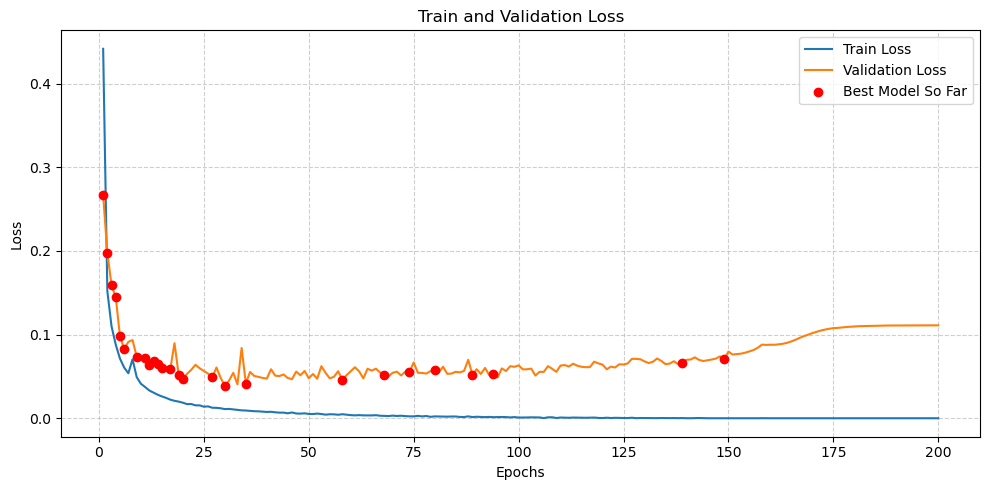

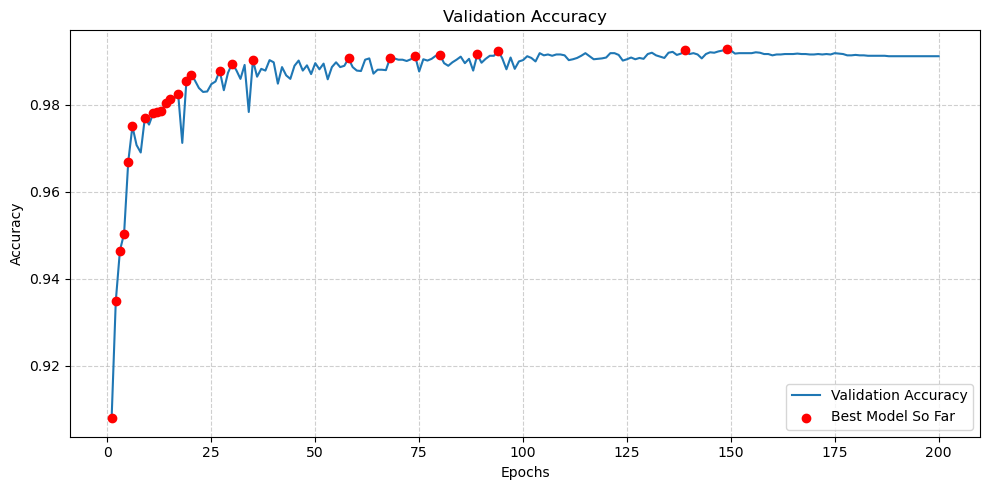

In [20]:
if if_train:
    # x-axis
    epochs = range(1, num_epochs + 1)

    # train and val loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.scatter(best_epochs, [val_losses[epoch-1] for epoch in best_epochs], 
                color='red', label="Best Model So Far", zorder=5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # val accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.scatter(best_epochs, [val_accuracies[epoch-1] for epoch in best_epochs], 
                color='red', label="Best Model So Far", zorder=5)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Prediction

In [21]:
model = HeartbeatModel(input_dim, num_classes, num_layers, dropout)
model.load_state_dict(torch.load("best_heartbeat_model.pth"))
model.to(device)

def test_model(model, test_loader, criterion):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.

    Returns:
        dict: Dictionary containing test loss, accuracy, and additional metrics.
    """
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    abs_sum_total = 0.0
    sample_num = 0

    with torch.no_grad():
        for batch in test_loader:
            signals, labels = batch
            signals, labels = signals.to(device), labels.to(device)

            outputs = model(signals) # outputs before softmax
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # One-hot of true label
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

            # abs-sum
            abs_sum_batch = torch.sum(torch.abs(labels_one_hot - probs))
            abs_sum_total += abs_sum_batch.item()
            sample_num += labels.size(0)

    abs_sum_avg = abs_sum_total / sample_num
    abs_sum = abs_sum_avg * 20000 # simulate sample.csv
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    print(f'Average abs-sum: {abs_sum_avg:.4f}')
    print(f'Total abs-sum: {abs_sum:.1f}')

test_model(model, test_loader, criterion)

/tmp/ipykernel_2598111/1477287630.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_heartbeat_model.pth"))


Test Loss: 0.0768
Test Accuracy: 99.16%
Average abs-sum: 0.0172
Total abs-sum: 343.4
